# Loading Data

In [14]:
import pandas as pd

In [13]:
train_df = pd.read_csv('./Fraudulent_E-Commerce_Transaction_Data.csv')
test_df = pd.read_csv('./Fraudulent_E-Commerce_Transaction_Data_2.csv')

In [15]:
train_df

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472947,c8604004-2f4c-42ce-a1c4-cd2bebca79bb,f8a534ad-0458-465e-a85b-3ad2cdf391bc,208.48,2024-01-12 23:39:55,PayPal,health & beauty,2,29,North Laurafort,desktop,27.245.104.92,USNV Griffin\nFPO AA 52700,USNV Griffin\nFPO AA 52700,0,149,23
1472948,fff0df19-fd4a-42a5-bc42-64bb7b02edb0,f2ef2239-d9b9-40d0-9993-4b8f305d5a7b,231.57,2024-03-27 04:31:45,credit card,clothing,2,32,Burnsville,tablet,203.54.50.163,"478 John Square Apt. 235\nMillerhaven, GA 68797","478 John Square Apt. 235\nMillerhaven, GA 68797",0,132,4
1472949,9e79012f-e00b-47d1-8700-0c302db20d3e,fa5b9a25-9606-478a-8abe-ef20bbb3980f,101.80,2024-01-31 23:51:42,bank transfer,electronics,4,36,Garciafort,mobile,51.241.30.149,"351 Frazier Radial Apt. 989\nPort Charles, OH ...","182 House Island Suite 198\nEast Scott, FM 84301",0,98,23
1472950,917066b1-4dfb-4472-b3f0-292663c45d21,04524272-e14f-460b-bc70-5316bd28463d,61.80,2024-01-12 16:21:32,bank transfer,electronics,5,34,Lake Josephberg,desktop,210.67.203.4,"27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...","27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...",0,191,16


In [16]:
train_df.shape

(1472952, 16)

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472952 entries, 0 to 1472951
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Transaction ID      1472952 non-null  object 
 1   Customer ID         1472952 non-null  object 
 2   Transaction Amount  1472952 non-null  float64
 3   Transaction Date    1472952 non-null  object 
 4   Payment Method      1472952 non-null  object 
 5   Product Category    1472952 non-null  object 
 6   Quantity            1472952 non-null  int64  
 7   Customer Age        1472952 non-null  int64  
 8   Customer Location   1472952 non-null  object 
 9   Device Used         1472952 non-null  object 
 10  IP Address          1472952 non-null  object 
 11  Shipping Address    1472952 non-null  object 
 12  Billing Address     1472952 non-null  object 
 13  Is Fraudulent       1472952 non-null  int64  
 14  Account Age Days    1472952 non-null  int64  
 15  Transaction Hou

In [23]:
train_df.describe()

,Transaction Amount,Quantity,Customer Age,Is Fraudulent,Account Age Days,Transaction Hour
count,1.472952e+06,1.472952e+06,1.472952e+06,1.472952e+06,1.472952e+06,1.472952e+06
mean,2.267683e+02,3.000230e+00,3.451208e+01,5.012926e-02,1.796464e+02,1.128696e+01
std,2.703951e+02,1.414736e+00,1.000313e+01,2.182117e-01,1.068642e+02,6.975995e+00
min,1.000000e+01,1.000000e+00,-1.600000e+01,0.000000e+00,1.000000e+00,0.000000e+00
25%,6.861000e+01,2.000000e+00,2.800000e+01,0.000000e+00,8.600000e+01,5.000000e+00
50%,1.517600e+02,3.000000e+00,3.500000e+01,0.000000e+00,1.790000e+02,1.100000e+01
75%,2.960500e+02,4.000000e+00,4.100000e+01,0.000000e+00,2.720000e+02,1.700000e+01
max,1.270175e+04,5.000000e+00,8.600000e+01,1.000000e+00,3.650000e+02,2.300000e+01


# Exploratory Data Analysis

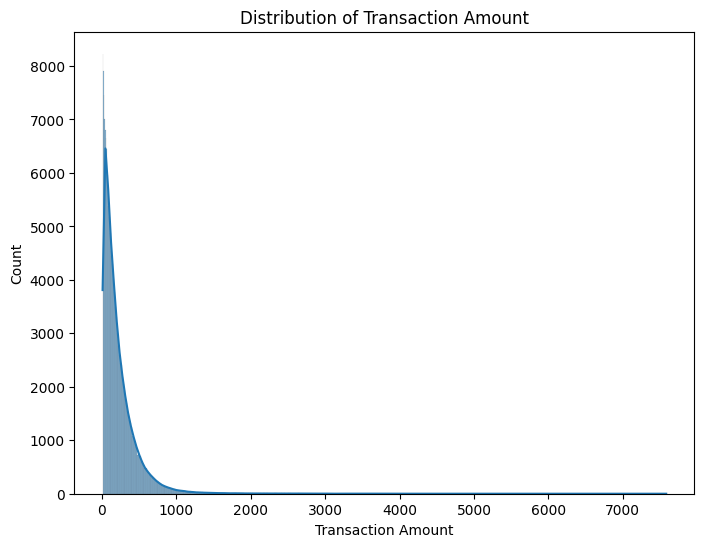

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(df['Transaction Amount'], kde=True)
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Distribution of Transaction Amount')
plt.show()